In [1]:
import torch
import torch.nn as nn
from pau import PAU

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator

torch.set_grad_enabled(False)

In [2]:
# from train_basis
lat_dim = 8

def init_sequential(layers):
    modules = []
    for i in range(len(layers)-2):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        modules.append(PAU(initial_shape='relu'))
    modules.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*modules)

approximator = init_sequential([100, lat_dim])
trunk = init_sequential([2, 100, 100, 100, 100, lat_dim])

model_data =torch.load('dataset/ds20k/model/2000_ds20k_basis_enc_8basis.model')

approximator.load_state_dict(model_data['A'][0])
trunk.load_state_dict(model_data['T'][0])
epoch = model_data['epoch']

In [3]:
print(trunk)
print(approximator)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): PAU(m=5, n=4, efficient=True)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): PAU(m=5, n=4, efficient=True)
  (8): Linear(in_features=100, out_features=8, bias=True)
)
Sequential(
  (0): Linear(in_features=100, out_features=8, bias=True)
)


In [3]:
def model(xb, p):
    '''
        xb [bs]x[enc_dim]
        p  [points]x[2]
    '''
    A = approximator(xb)         # -> [bs]x[lat_dim]
    D = trunk(p.T)               # -> [points]x[lat_dim]
    return A @ D.T

In [4]:
n_elem = 100
area_elem = (1/(n_elem-1))
int_p_1d = torch.linspace(0, 1, n_elem)
int_w_1d = torch.ones(n_elem)
int_w_1d[[0, -1]] /= 2

int_p = torch.stack(torch.meshgrid(int_p_1d, int_p_1d, indexing='xy')).view(2, -1)
int_w = (torch.kron(int_w_1d, int_w_1d) * area_elem**2).ravel()

def loss_fun(Y, netX):
    return (((Y - netX)**2 @ int_w) / (Y**2 @ int_w)).mean()

In [5]:
def encode(x):
    k = 0
    result = torch.zeros(100)
    for i in range(1, 11):
        for j in range(1, 11):
            k1 = torch.tensor(i)
            k2 = torch.tensor(j)
            y_ij = torch.sin(k1*int_p[0]) * torch.sin(k2*int_p[1]) * x @ int_w
            norm = torch.sqrt(torch.sin(k1*int_p[0]) * torch.sin(k2*int_p[1]) @ int_w)
            result[k] = y_ij / norm
            k += 1
        
    return result

/home/dasvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


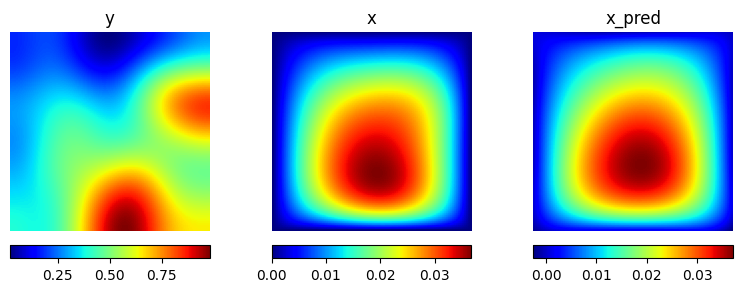

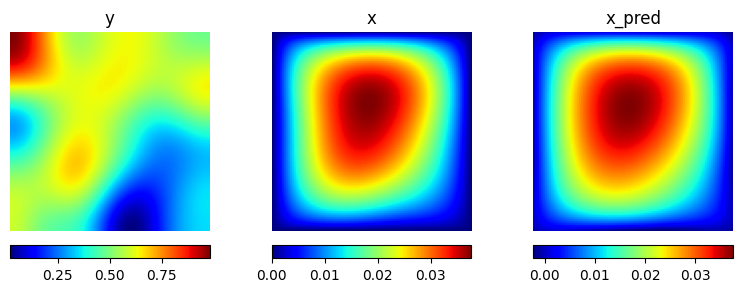

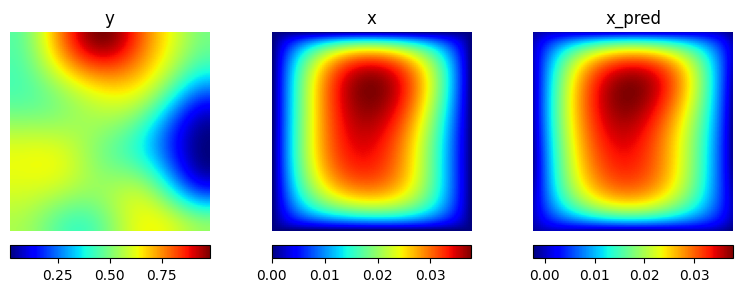

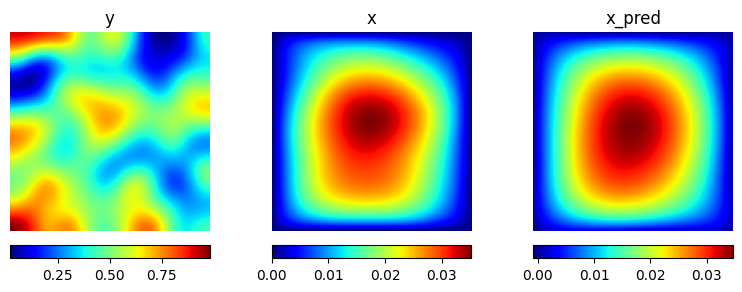

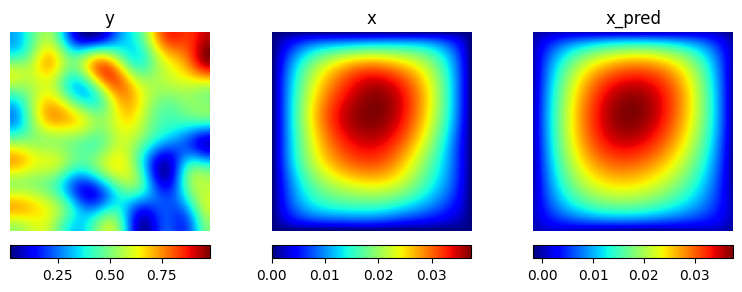

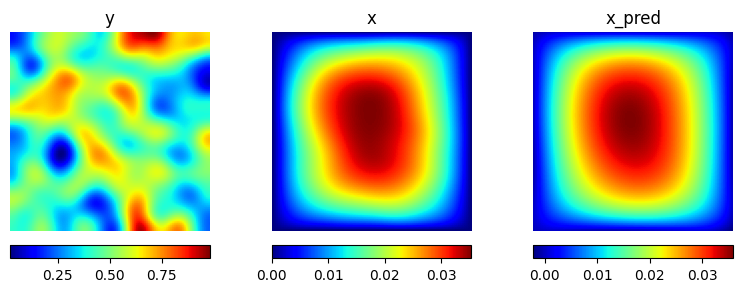

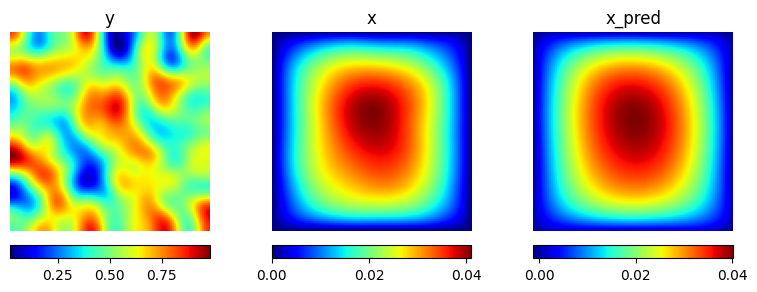

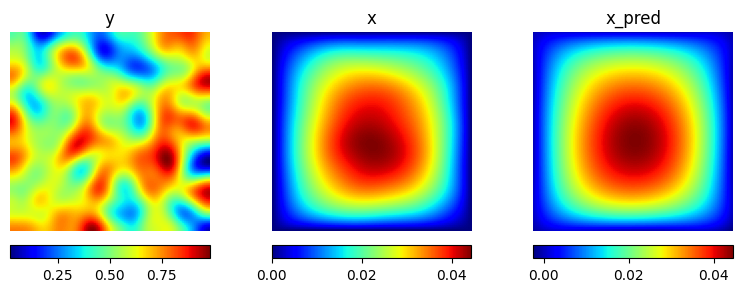

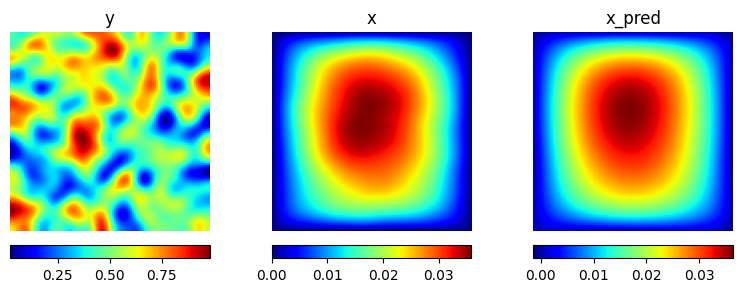

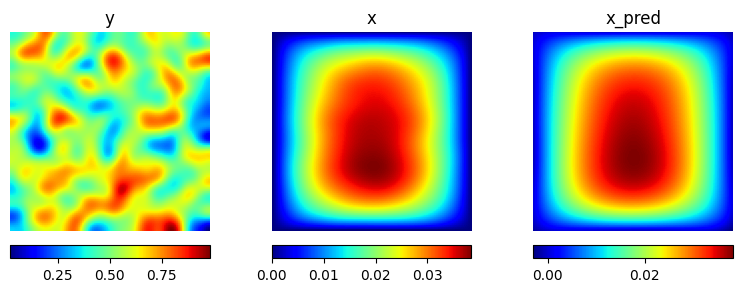

In [8]:
path = 'dataset/ds20k/valid/'
size = 2_000

for i in range(0, size, size//10):
    Y = torch.load(path + f'{i}_Y.pt').detach()
    X = torch.load(path + f'{i}_X.pt').detach()

    ip = torch.linspace(0, 1, len(X)).numpy()

    int_y = torch.tensor(RegularGridInterpolator((ip, ip), Y.numpy())(int_p.T.numpy())).float()
    
    data = torch.zeros(1, 10*10)
    data[0, :] = encode(int_y)

    x_pred = model(data, int_p).detach()
    x = torch.tensor(RegularGridInterpolator((ip, ip), X.numpy())(int_p.T.numpy())).float()

    loss = loss_fun(x, x_pred).item()

    x_pred = x_pred.ravel()
    
    fig, ax = plt.subplots(ncols=3, figsize=(8, 4))
    fig.tight_layout()
    
    c1 = ax[0].imshow(RegularGridInterpolator((ip, ip), Y.numpy())(int_p.T.numpy()).reshape((100, 100)), cmap='jet')
    ax[0].set_title('y')
    ax[0].axis('off')
    
    c2 = ax[1].imshow(x.reshape((100,100)), cmap='jet')
    ax[1].set_title('x')
    ax[1].axis('off')

    c3 = ax[2].imshow(x_pred.reshape((100, 100)), cmap='jet')
    ax[2].set_title('x_pred')
    ax[2].axis('off')

    plt.colorbar(c1, ax=ax[0], location='bottom', aspect=15, pad=0.04)
    plt.colorbar(c2, ax=ax[1], location='bottom', aspect=15, pad=0.04)
    plt.colorbar(c3, ax=ax[2], location='bottom', aspect=15, pad=0.04)

    plt.savefig(f'figures/epoch_{epoch}_basis_enc_{i}.png', bbox_inches='tight')
    plt.show()

# Basis

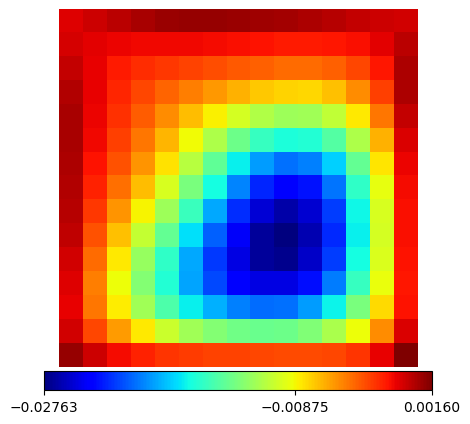

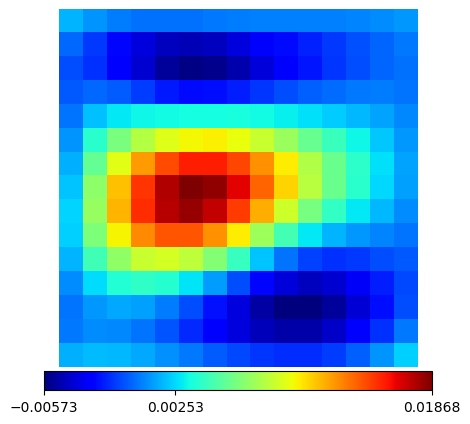

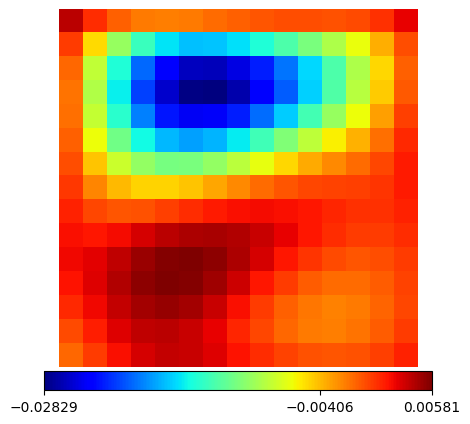

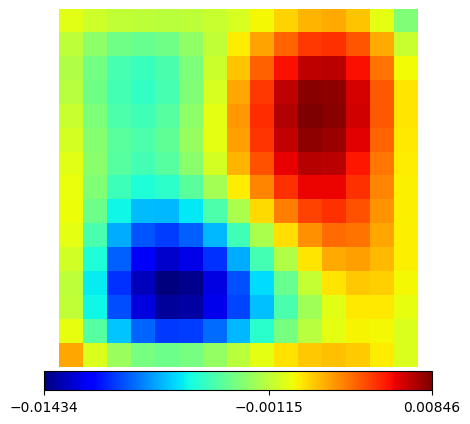

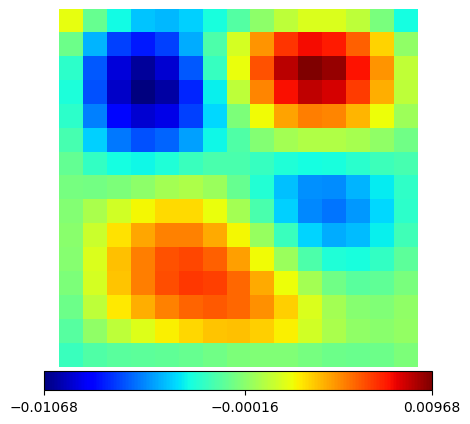

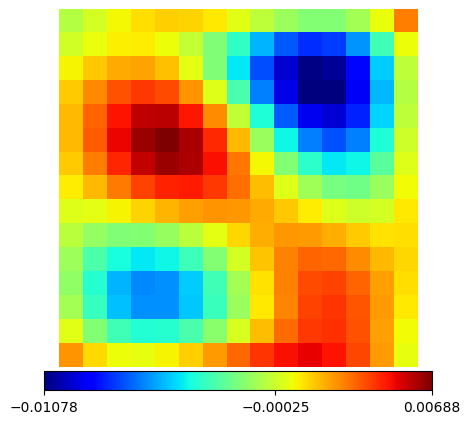

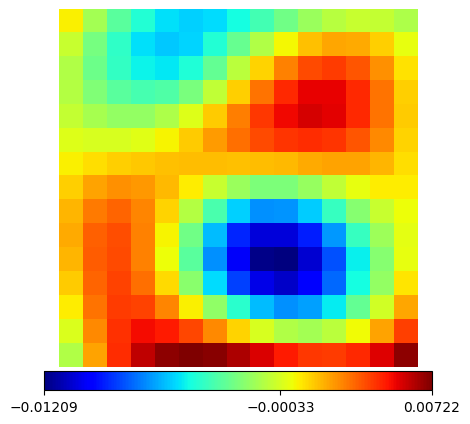

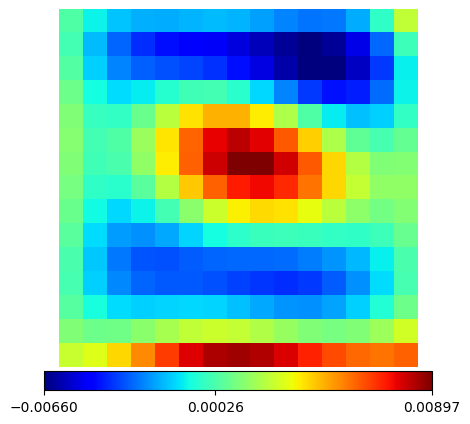

In [25]:
#  First: show learned eigenbasis
#  Second: apply gram schmidt and show learned orthonormalize eigenbasis

NT = 15
t = torch.linspace(0, 1, NT)
t = torch.stack(torch.meshgrid(t, t, indexing='xy')).view(2, -1)

BASIS = trunk(t.T).T.detach()

#  Quadrature rule
n_elem = NT
area_elem = (1/(n_elem-1))
int_p_1d = torch.linspace(0, 1, n_elem)
int_w_1d = torch.ones(n_elem)
int_w_1d[[0, -1]] /= 2

int_p = torch.stack(torch.meshgrid(int_p_1d, int_p_1d, indexing='xy')).view(2, -1)
int_w = (torch.kron(int_w_1d, int_w_1d) * area_elem**2).ravel()
#  End Quadrature rule

def compute_EIGV(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        num = (b * model(encode(b), int_p)) @ int_w
        den = (b * b) @ int_w
        EIGV.append((num / den).detach())
    
    return torch.tensor(EIGV)

EIGV = compute_EIGV(BASIS)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]
for i, b in enumerate(BASIS):
    plt.figure(figsize=(5,5))
    plt.imshow(b.view(NT, NT), cmap='jet')
    plt.axis('off')
    plt.colorbar(location='bottom', fraction=0.06, pad=0.01, ticks=[torch.min(b), torch.mean(b),torch.max(b)])
    plt.savefig(f'figures/epoch_{epoch}_basis_enc_basis_{i}_resolution_{NT}.png', bbox_inches='tight')
    plt.show()

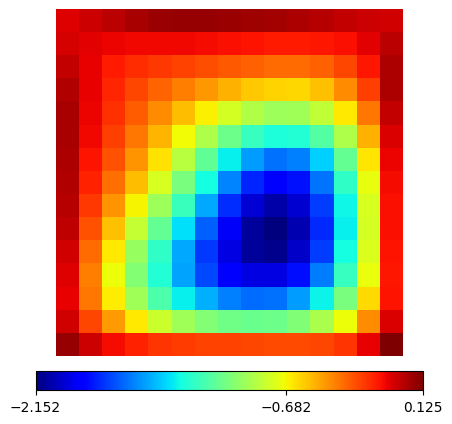

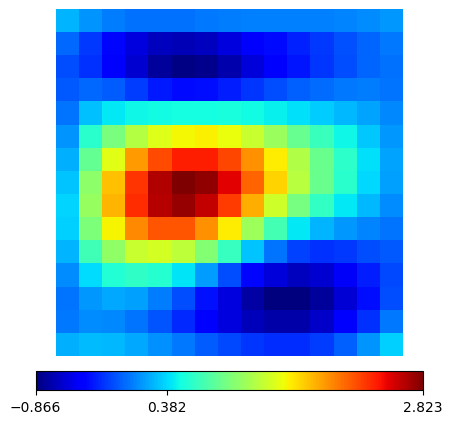

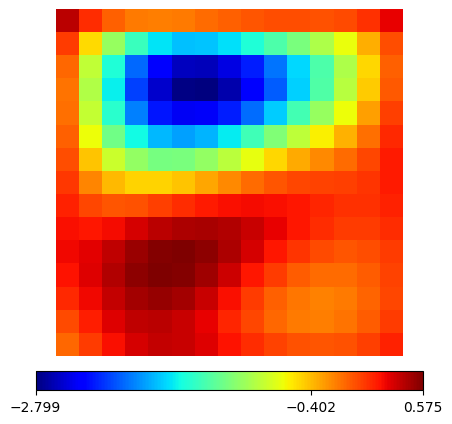

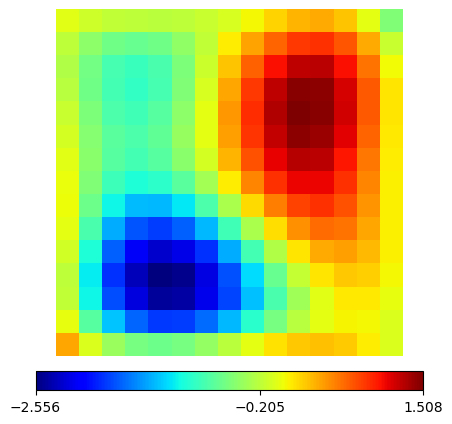

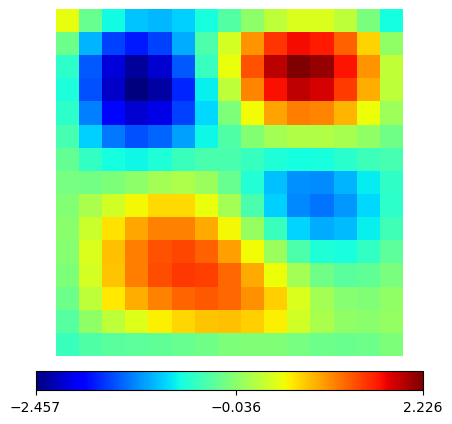

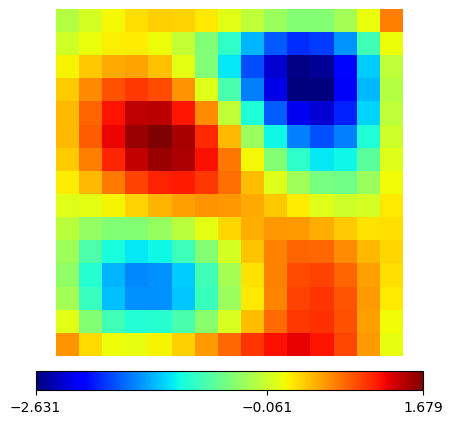

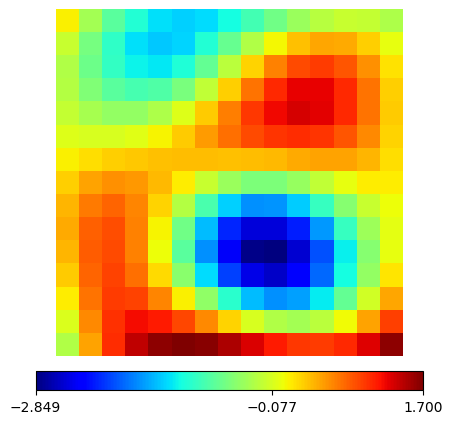

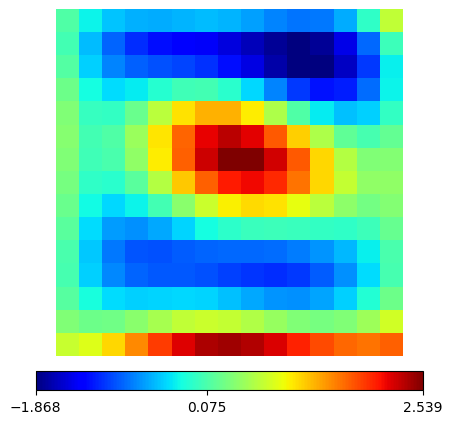

In [26]:
#  Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w
        if abs(R[i][j]) >= 0.1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

O_BASIS = torch.stack(Q)
for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.view(NT, NT), cmap='jet')
    plt.axis('off')
    plt.colorbar(location='bottom', fraction=0.06, pad=0.04, ticks=[torch.min(b), torch.mean(b),torch.max(b)])
    plt.savefig(f'figures/epoch_{epoch}_basis_enc_basis_orth_{i}_resolution_{NT}.png', bbox_inches='tight')
    plt.show()

O_EIGV = compute_EIGV(O_BASIS)

idx = torch.argsort(O_EIGV, descending=True)

O_EIGV = O_EIGV[idx]
O_BASIS = O_BASIS[idx]

# Basis2Kernel

In [27]:
G = torch.zeros(NT**2, NT**2)
k = 0
for k, (i, j) in enumerate([(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1)]): 
    G += torch.outer(O_BASIS[k], O_BASIS[k]) * O_EIGV[k]

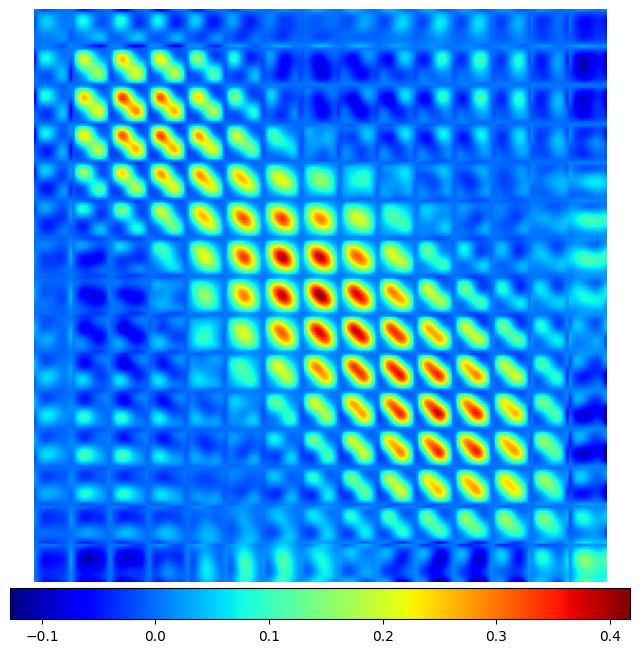

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(G, cmap='jet')
plt.axis('off')
plt.colorbar(location='bottom', fraction=0.06, pad=0.01)
plt.savefig(f'figures/epoch_{epoch}_basis2kernel_matrix_resolution_{N}.png', bbox_inches='tight')
plt.show()